This Python notebook is focused on the usage of Neural Networks and Support Vector Regression for the task of WN the specific application, Energy Forecasting (based on weather) (as is described in the Thesis: "ML-ASSISTED DATA ANALYTICS AND WEATHER NORMALIZATION TO AID IN COMMERCIAL BUILDING ENERGY AUDITS").

# Libraries & Packages

In [ ]:
pip install tensorflow

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Import and organize data:

# Importing MONTHLY file from GitHub for Monthly Data
url_monthly = 'https://raw.githubusercontent.com/gvanwalsen/adv-weather-norm/main/LV_B1_monthlyrawdata.csv'
df_monthly = pd.read_csv(url_monthly)

# Importing DAILY file from GitHub for Daily SVR attempt
url_daily = 'https://raw.githubusercontent.com/gvanwalsen/adv-weather-norm/main/LV_B1_dailyrawdata.csv'
df_daily = pd.read_csv(url_daily)

# Importing HOURLY file from GitHub for Daily SVR attempt
url_hourly = 'https://raw.githubusercontent.com/gvanwalsen/adv-weather-norm/main/LV_B1_hourlyrawdata.csv'
df_hourly = pd.read_csv(url_hourly)

# Light Data Re-arrangement
b1_daily_arr = np.array(df_daily)
b1_daily_raw = b1_daily_arr[0:1461,0:32]
# print(b1_daily_raw)

b1_hourly_arr = np.array(df_hourly)
b1_hourly_raw = b1_hourly_arr[0:36064,0:25]
# print(b1_hourly_raw)

b1_monthly_arr = np.array(df_monthly)
b1_monthly_raw = b1_monthly_arr[0:72,0:32]
# print(b1_monthly_raw)

b1_daily_df = pd.DataFrame({ 'Year': b1_daily_raw[:,1],
                            'Month': b1_daily_raw[:,2],
                             'Day': b1_daily_raw[:,3],
                                'EnergyUse': b1_daily_raw[:,6],
                                'Temp': b1_daily_raw[:,9],
                                'feelslike': b1_daily_raw[:,12],
                                'RelHum': b1_daily_raw[:,13],
                                'Humidity': b1_daily_raw[:,14],
                                'Precip': b1_daily_raw[:,15],
                                'Snow': b1_daily_raw[:,19],
                                'WindGust': b1_daily_raw[:,21],
                                'WindSpeed': b1_daily_raw[:,22],
                                'WindDir': b1_daily_raw[:,23],
                                'SeaLevelPressure': b1_daily_raw[:,24],
                                'CloudCover': b1_daily_raw[:,25],
                                'Visibility': b1_daily_raw[:,26],
                                'SolarRadiation': b1_daily_raw[:,27],
                                'SolarEnergy': b1_daily_raw[:,28],
                                'UVIndex': b1_daily_raw[:,29]})

b1_daily_df['datetime'] = pd.to_datetime(b1_daily_df[['Year', 'Month', 'Day']])


b1_hourly_df = pd.DataFrame({ 'Year': b1_hourly_raw[:,0],
                                'Month': b1_hourly_raw[:,1],
                                'Day': b1_hourly_raw[:,2],
                                'Hour': b1_hourly_raw[:,3],
                                'EnergyUse': b1_hourly_raw[:,6],
                                'Temp': b1_hourly_raw[:,7],
                                'feelslike': b1_hourly_raw[:,8],
                                'RelHum': b1_hourly_raw[:,9],
                                'Humidity': b1_hourly_raw[:,10],
                                'Precip': b1_hourly_raw[:,11],
                                'Snow': b1_hourly_raw[:,14],
                                'WindGust': b1_hourly_raw[:,16],
                                'WindSpeed': b1_hourly_raw[:,17],
                                'WindDir': b1_hourly_raw[:,18],
                                'SeaLevelPressure': b1_hourly_raw[:,19],
                                'CloudCover': b1_hourly_raw[:,20],
                                'Visibility': b1_hourly_raw[:,21],
                                'SolarRadiation': b1_hourly_raw[:,22],
                                'SolarEnergy': b1_hourly_raw[:,23],
                                'UVIndex': b1_hourly_raw[:,24]})

b1_hourly_df['datetime'] = pd.to_datetime(b1_hourly_df[['Year', 'Month', 'Day', 'Hour']])

b1_monthly_df = pd.DataFrame({ 'Year': b1_monthly_raw[:,0],
                                'Month': b1_monthly_raw[:,1],
                                'EnergyUse': b1_monthly_raw[:,3],
                                'Temp': b1_monthly_raw[:,6],
                                'feelslike': b1_monthly_raw[:,9],
                                'RelHum': b1_monthly_raw[:,10],
                                'Humidity': b1_monthly_raw[:,11],
                                'Precip': b1_monthly_raw[:,12],
                                'Snow': b1_monthly_raw[:,16],
                                'WindGust': b1_monthly_raw[:,18],
                                'WindSpeed': b1_monthly_raw[:,19],
                                'WindDir': b1_monthly_raw[:,20],
                                'SeaLevelPressure': b1_monthly_raw[:,21],
                                'CloudCover': b1_monthly_raw[:,22],
                                'Visibility': b1_monthly_raw[:,23],
                                'SolarRadiation': b1_monthly_raw[:,24],
                                'SolarEnergy': b1_monthly_raw[:,25],
                                'UVIndex': b1_monthly_raw[:,26]})

# Feature Scaling (necessary for data to be scaled down ahead of NN processing)
sc_Xd = StandardScaler()
sc_yd = StandardScaler()

# Building 1, NN (Energy Forecasting, Monthly)

In [ ]:
# Start with Monthly Data, Temperature & Energy Use
# Seperate Data by Year (MONTHLY)
b1_monthly_1923 = b1_monthly_df[(b1_monthly_df['Year'] == 2019) | (b1_monthly_df['Year'] == 2020) | (b1_monthly_df['Year'] == 2021) | (b1_monthly_df['Year'] == 2022) | (b1_monthly_df['Year'] == 2023)] # "Baseline" Years
b1_monthly_2024 = b1_monthly_df[(b1_monthly_df['Year'] == 2024)] # "Subject" Year

b1_monthly_2019 = b1_monthly_df[(b1_monthly_df['Year'] == 2019)]
b1_monthly_2020 = b1_monthly_df[(b1_monthly_df['Year'] == 2020)]
b1_monthly_2021 = b1_monthly_df[(b1_monthly_df['Year'] == 2021)]
b1_monthly_2022 = b1_monthly_df[(b1_monthly_df['Year'] == 2022)]
b1_monthly_2023 = b1_monthly_df[(b1_monthly_df['Year'] == 2023)]

In [ ]:
# START WITH BASELINE YEARS (2019-2023)
X_m_ef_temp = sc_Xd.fit_transform(b1_monthly_1923[['Temp']])
Y_m_ef_ener = sc_yd.fit_transform(b1_monthly_1923[['EnergyUse']])

# THEN, PREDICITION YEAR (2024)
X_m_ef_temp_pred = sc_Xd.fit_transform(b1_monthly_2024[['Temp']])
Y_m_ef_ener_pred = sc_yd.fit_transform(b1_monthly_2024[['EnergyUse']])

In [ ]:
# Assign data (using just 2019-2023)
X_m_ef_bas_nn = X_m_ef_temp.astype(float)
y_m_ef_bas_nn = Y_m_ef_ener.astype(float)

# Assign Data (2024)
X_m_ef_pred_nn = X_m_ef_temp_pred.astype(float)
y_m_ef_pred_nn = Y_m_ef_ener_pred.astype(float)

# Split into training and testing for 2019-2023 (30% test, 70% train)
X_nn_m_ef_bas_train, X_nn_m_ef_bas_test, y_nn_m_ef_bas_train, y_nn_m_ef_bas_test = train_test_split(X_m_ef_bas_nn, y_m_ef_bas_nn, test_size=0.3, random_state=42)

In [ ]:
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, activation='relu', input_shape=input_shape, return_sequences=True),
        SimpleRNN(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for single-step forecasting
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
# Train standard reccurent model
seq_length_m_ef_bas = len(X_m_ef_bas_nn)
model_m_ef = build_rnn_model((seq_length_m_ef_bas, 1))
early_stopping_m_ef = EarlyStopping(patience=10, restore_best_weights=True)

model_m_ef.fit(
    X_nn_m_ef_bas_train, y_nn_m_ef_bas_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_m_ef],
    verbose=1
)

m_ef_nn_test_loss = model_m_ef.evaluate(X_nn_m_ef_bas_test, y_nn_m_ef_bas_test)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - loss: 0.8831 - val_loss: 0.5190
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.8790 - val_loss: 0.5170
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.8422 - val_loss: 0.5137
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8064 - val_loss: 0.5095
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.8103 - val_loss: 0.5047
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.7811 - val_loss: 0.5026
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.7750 - val_loss: 0.5012
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.7456 - val_loss: 0.4996
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.7718 - val_loss: 0.4978
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.7606 - val_loss: 0.4957
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.7324 - val_loss: 0.4937
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7238 - val_loss: 0.4919
Epoch 13

In [ ]:
# Train LSTM model, trying it out
model_lstm_m_ef = build_lstm_model((seq_length_m_ef_bas, 1))
model_lstm_m_ef.fit(
    X_nn_m_ef_bas_train, y_nn_m_ef_bas_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_m_ef],
    verbose=1
)

m_ef_nn_lstm_test_loss = model_lstm_m_ef.evaluate(X_nn_m_ef_bas_test, y_nn_m_ef_bas_test)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 815ms/step - loss: 0.8959 - val_loss: 0.6395
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.8930 - val_loss: 0.6342
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.8961 - val_loss: 0.6299
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.8858 - val_loss: 0.6258
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.8816 - val_loss: 0.6217
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.8773 - val_loss: 0.6177
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.8601 - val_loss: 0.6136
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.8575 - val_loss: 0.6100
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.8654 - val_loss: 0.6062
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.8611 - val_loss: 0.6017
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.8569 - val_loss: 0.5969
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.8536 - val_los

In [ ]:
# Make predicition using trained baseline model
m_ef_nn_predictions = model_m_ef.predict(X_m_ef_pred_nn)
# m_ef_nn_lstm_predictions = model_lstm_m_ef.predict(X_m_ef_pred_nn)

# Extract the MAE from standard model
mae_m_ef_bas_value = mean_absolute_error(y_m_ef_pred_nn, m_ef_nn_predictions)
mae_m_ef_bas_round = round(mae_m_ef_bas_value, 3)

# Extract the R2 from standard model
r2_m_ef_bas_value = r2_score(y_m_ef_pred_nn, m_ef_nn_predictions)
r2_result_m_bas_round = round(r2_m_ef_bas_value, 3)

'''
# Extract the MAE from LSTM model
mae_m_ef_bas_lstm_value = mean_absolute_error(y_m_ef_pred_nn, m_ef_nn_lstm_predictions)
mae_m_ef_bas_lstm_round = round(mae_m_ef_bas_lstm_value, 3)

# Extract the R2 from LSTM model
r2_m_ef_bas_lstm_value = r2_score(y_m_ef_pred_nn, m_ef_nn_lstm_predictions)
r2_result_m_bas_lstm_round = round(r2_m_ef_bas_lstm_value, 3)
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


'\n# Extract the MAE from LSTM model\nmae_m_ef_bas_lstm_value = mean_absolute_error(y_m_ef_pred_nn, m_ef_nn_lstm_predictions)\nmae_m_ef_bas_lstm_round = round(mae_m_ef_bas_lstm_value, 3)\n\n# Extract the R2 from LSTM model\nr2_m_ef_bas_lstm_value = r2_score(y_m_ef_pred_nn, m_ef_nn_lstm_predictions)\nr2_result_m_bas_lstm_round = round(r2_m_ef_bas_lstm_value, 3)\n'

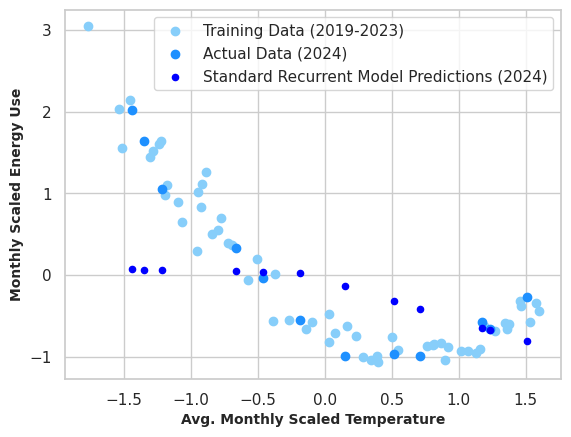

Standard Recurrent Model MAE:
0.676
R2 Score:
0.215


'\nprint("LSTM Model MAE:")\nprint(mae_m_ef_bas_lstm_round)\nprint("R2 Score:")\nprint(r2_result_m_bas_lstm_round)\n'

In [ ]:
# Plot the model
sns.set(style="whitegrid")
plt.scatter(X_m_ef_bas_nn, y_m_ef_bas_nn, label='Training Data (2019-2023)', color='lightskyblue')
plt.scatter(X_m_ef_pred_nn, y_m_ef_pred_nn, label='Actual Data (2024)', color='dodgerblue')
plt.scatter(X_m_ef_pred_nn, m_ef_nn_predictions, label='Standard Recurrent Model Predictions (2024)', color='blue', s=20)
#plt.scatter(X_m_ef_pred_nn, m_ef_nn_lstm_predictions, label='LSTM Model Predictions (2024)', color='blue', s=20)
plt.xlabel('Avg. Monthly Scaled Temperature', fontweight ='bold', fontsize = 10)
plt.ylabel('Monthly Scaled Energy Use', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

print("Standard Recurrent Model MAE:")
print(mae_m_ef_bas_round)
print("R2 Score:")
print(r2_result_m_bas_round)
'''
print("LSTM Model MAE:")
print(mae_m_ef_bas_lstm_round)
print("R2 Score:")
print(r2_result_m_bas_lstm_round)
'''

/tmp/ipython-input-34070142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_monthly_1923['timestamp'] = plot_monthly_1923['Month'].astype(str) + ',' + ' ' + plot_monthly_1923['Year'].astype(str)
/tmp/ipython-input-34070142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b1_monthly_2024['timestamp'] = b1_monthly_2024['Month'].astype(str) + ',' + ' ' + b1_monthly_2024['Year'].astype(str)


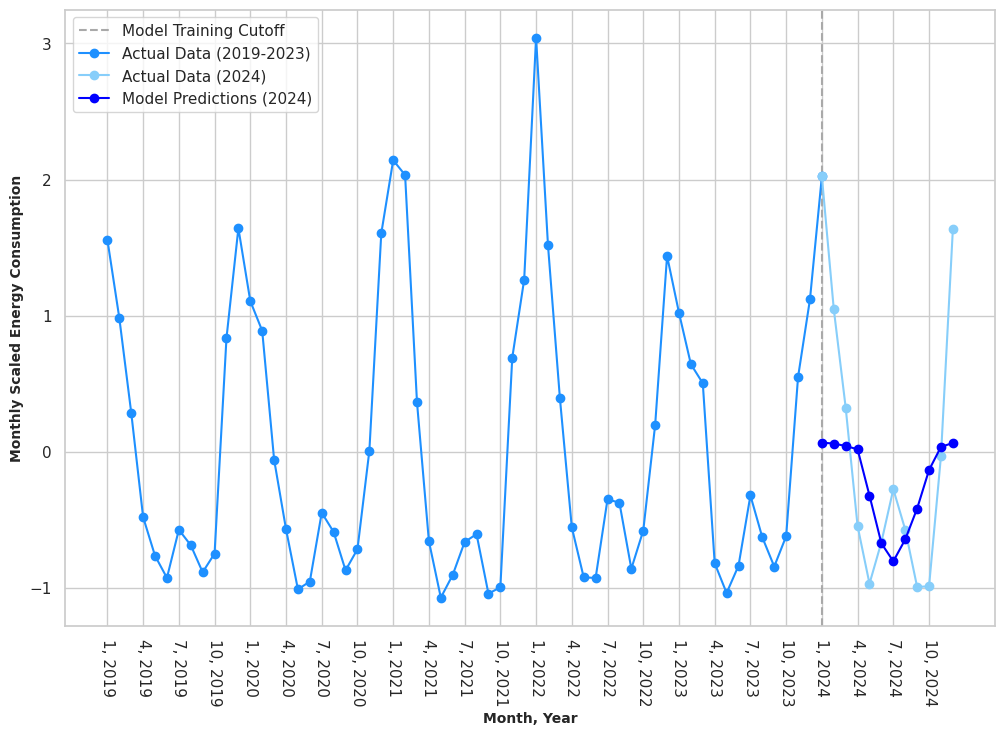

In [ ]:
# Prep portion of plot
plot_monthly_1923 = b1_monthly_df[(b1_monthly_df['Year'] == 2019) | (b1_monthly_df['Year'] == 2020) | (b1_monthly_df['Year'] == 2021) | (b1_monthly_df['Year'] == 2022) | (b1_monthly_df['Year'] == 2023) |
                                  (b1_monthly_df['Year'] == 2024) & (b1_monthly_df['Month'] == 1)]
plot_monthly_1923['timestamp'] = plot_monthly_1923['Month'].astype(str) + ',' + ' ' + plot_monthly_1923['Year'].astype(str)
b1_monthly_2024['timestamp'] = b1_monthly_2024['Month'].astype(str) + ',' + ' ' + b1_monthly_2024['Year'].astype(str)

y_m_ef_pred_nn_weather = y_m_ef_pred_nn[0]
y_m_ef_bas_nn_plot = np.concatenate((y_m_ef_bas_nn.flatten(), y_m_ef_pred_nn_weather))

# Plot the data in time series
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.axvline(60, color='darkgrey', linestyle='--', label='Model Training Cutoff')
plt.plot(plot_monthly_1923['timestamp'], y_m_ef_bas_nn_plot, color='dodgerblue', label='Actual Data (2019-2023)', marker='o')
plt.plot(b1_monthly_2024['timestamp'], y_m_ef_pred_nn, color='lightskyblue', label='Actual Data (2024)', marker='o')
plt.plot(b1_monthly_2024['timestamp'], m_ef_nn_predictions, color='blue', label='Model Predictions (2024)', marker='o')
plt.xlabel('Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Monthly Scaled Energy Consumption', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 72, 3))
plt.tick_params(axis ='x', rotation = -90)
plt.legend()
plt.show()

# Building 1, SVM (Energy Forecasting, Monthly)

In [ ]:
# Start with Monthly Data, Temperature & Energy Use
# Seperate Data by Year (MONTHLY)
b1_monthly_1923 = b1_monthly_df[(b1_monthly_df['Year'] == 2019) | (b1_monthly_df['Year'] == 2020) | (b1_monthly_df['Year'] == 2021) | (b1_monthly_df['Year'] == 2022) | (b1_monthly_df['Year'] == 2023)] # "Baseline" Years
b1_monthly_2024 = b1_monthly_df[(b1_monthly_df['Year'] == 2024)] # "Subject" Year

b1_monthly_2019 = b1_monthly_df[(b1_monthly_df['Year'] == 2019)]
b1_monthly_2020 = b1_monthly_df[(b1_monthly_df['Year'] == 2020)]
b1_monthly_2021 = b1_monthly_df[(b1_monthly_df['Year'] == 2021)]
b1_monthly_2022 = b1_monthly_df[(b1_monthly_df['Year'] == 2022)]
b1_monthly_2023 = b1_monthly_df[(b1_monthly_df['Year'] == 2023)]

In [ ]:
# START WITH BASELINE YEARS (2019-2023)
X_m_ef_svm_temp = sc_Xd.fit_transform(b1_monthly_1923[['Temp']])
Y_m_ef_svm_ener = sc_yd.fit_transform(b1_monthly_1923[['EnergyUse']])

# THEN, PREDICITION YEAR (2024)
X_m_ef_svm_temp_pred = sc_Xd.fit_transform(b1_monthly_2024[['Temp']])
Y_m_ef_svm_ener_pred = sc_yd.fit_transform(b1_monthly_2024[['EnergyUse']])

In [ ]:
# Assign data (using just 2019-2023)
X_m_ef_bas_svm = X_m_ef_svm_temp.astype(float)
y_m_ef_bas_svm = Y_m_ef_svm_ener.astype(float)

# Assign Data (2024)
X_m_ef_pred_svm = X_m_ef_svm_temp_pred.astype(float)
y_m_ef_pred_svm = Y_m_ef_svm_ener_pred.astype(float)

'''
# Split into training and testing for 2019-2023 (30% test, 70% train)
X_svm_m_ef_bas_train, X_svm_m_ef_bas_test, y_svm_m_ef_bas_train, y_svm_m_ef_bas_test = train_test_split(X_m_ef_bas_svm, y_m_ef_bas_svm, test_size=0.3, random_state=42)
'''

'\n# Split into training and testing for 2019-2023 (30% test, 70% train)\nX_svm_m_ef_bas_train, X_svm_m_ef_bas_test, y_svm_m_ef_bas_train, y_svm_m_ef_bas_test = train_test_split(X_m_ef_bas_svm, y_m_ef_bas_svm, test_size=0.3, random_state=42)\n'

In [ ]:
# Create SVR with Radial Basis Function (RBF) kernal
svr_m_ef = SVR(kernel='rbf')

In [ ]:
# Train model with exisiting data
svr_m_ef.fit(X_m_ef_bas_svm, y_m_ef_bas_svm)

# Make predicitions on the data
y_predictions_svm_m_ef = svr_m_ef.predict(X_m_ef_pred_svm)

'''
X_plot_m_win = pd.DataFrame(X_win_m_eval)
X_plot_m_win.columns=['x']
y_plot_m_win = pd.Series(y_pred_m_win, name='y')
plot_mon_win = pd.concat([X_plot_m_win, y_plot_m_win], axis=1)
plotsort_mon_win = plot_mon_win.sort_values(by='x')
'''

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


"\nX_plot_m_win = pd.DataFrame(X_win_m_eval)\nX_plot_m_win.columns=['x']\ny_plot_m_win = pd.Series(y_pred_m_win, name='y')\nplot_mon_win = pd.concat([X_plot_m_win, y_plot_m_win], axis=1)\nplotsort_mon_win = plot_mon_win.sort_values(by='x')\n"

In [ ]:
# Check performance of prediction
svr_r2_m_ef_svm = r2_score(y_m_ef_pred_svm, y_predictions_svm_m_ef)
svr_r2_m_ef_svm = round(svr_r2_m_ef_svm, 3)
print("R^2 Correlation for Predicition: ")
print(svr_r2_m_ef_svm)
svr_mae_m_ef_svm = mean_absolute_error(y_m_ef_pred_svm, y_predictions_svm_m_ef)
svr_mae_m_ef_svm = round(svr_mae_m_ef_svm, 3)
print("MAE in Predicition: ")
print(svr_mae_m_ef_svm)

R^2 Correlation for Predicition: 
0.972
MAE in Predicition: 
0.126


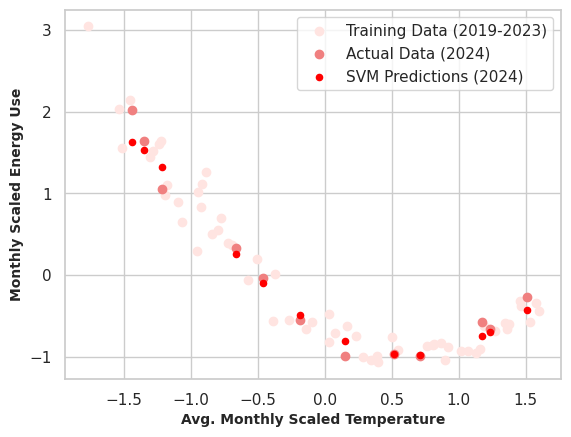

In [ ]:
# Plot the model
sns.set(style="whitegrid")
plt.scatter(X_m_ef_bas_svm, y_m_ef_bas_svm, label='Training Data (2019-2023)', color='mistyrose')
plt.scatter(X_m_ef_pred_svm, y_m_ef_pred_svm, label='Actual Data (2024)', color='lightcoral')
plt.scatter(X_m_ef_pred_svm, y_predictions_svm_m_ef, label='SVM Predictions (2024)', color='red', s=20)
plt.xlabel('Avg. Monthly Scaled Temperature', fontweight ='bold', fontsize = 10)
plt.ylabel('Monthly Scaled Energy Use', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

/tmp/ipython-input-1137460607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_monthly_1923['timestamp'] = plot_monthly_1923['Month'].astype(str) + ',' + ' ' + plot_monthly_1923['Year'].astype(str)


KeyError: 'timestamp'

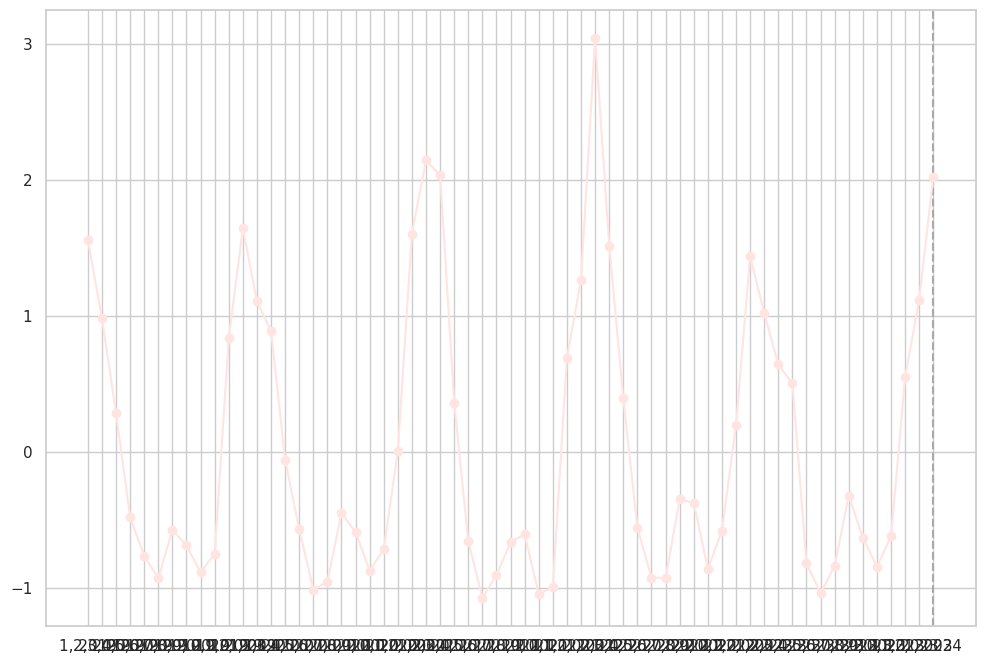

In [ ]:
# Prep portion of plot
plot_monthly_1923 = b1_monthly_df[(b1_monthly_df['Year'] == 2019) | (b1_monthly_df['Year'] == 2020) | (b1_monthly_df['Year'] == 2021) | (b1_monthly_df['Year'] == 2022) | (b1_monthly_df['Year'] == 2023) |
                                  (b1_monthly_df['Year'] == 2024) & (b1_monthly_df['Month'] == 1)]
plot_monthly_1923['timestamp'] = plot_monthly_1923['Month'].astype(str) + ',' + ' ' + plot_monthly_1923['Year'].astype(str)

y_m_ef_pred_svm_weather = y_m_ef_pred_svm[0]
y_m_ef_bas_svm_plot = np.concatenate((y_m_ef_bas_svm.flatten(), y_m_ef_pred_svm_weather))

# Plot the data in time series
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.axvline(60, color='darkgrey', linestyle='--', label='Model Training Cutoff')
plt.plot(plot_monthly_1923['timestamp'], y_m_ef_bas_svm_plot, color='mistyrose', label='Actual Data (2019-2023)', marker='o')
plt.plot(b1_monthly_2024['timestamp'], y_m_ef_pred_svm, color='lightcoral', label='Actual Data (2024)', marker='o')
plt.plot(b1_monthly_2024['timestamp'], y_predictions_svm_m_ef, color='red', label='Model Predictions (2024)', marker='o')
plt.xlabel('Month, Year', fontweight ='bold', fontsize = 10)
plt.ylabel('Monthly Scaled Energy Consumption', fontweight ='bold', fontsize = 10)
plt.xticks(np.arange(0, 72, 3))
plt.tick_params(axis ='x', rotation = -90)
plt.legend()
plt.show()

# Building 1 (Energy Forecasting, Monthly Comparison)

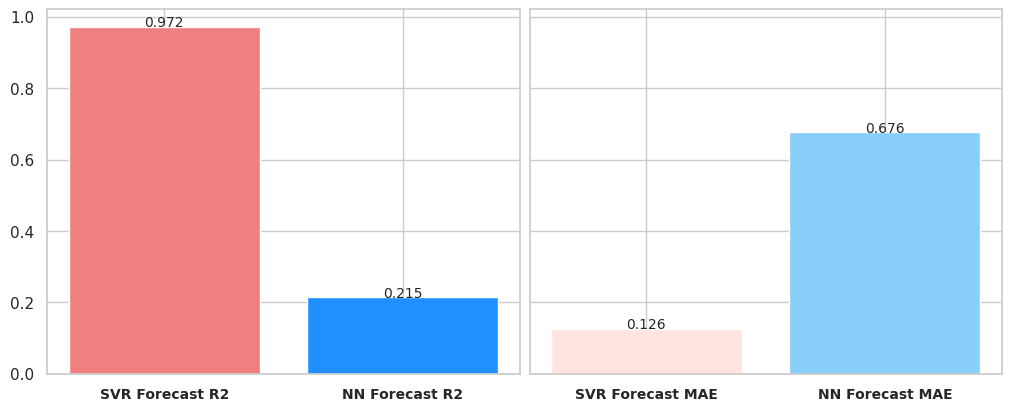

In [ ]:
# Compare monthly R2 and MAE Against Eachother
# Function to place labels at the center of each bar
def add_labels(ax, bar_positions, values):
    for i in range(len(values)):
        ax.text(bar_positions[i], values[i], values[i], ha='center', fontsize=10)  # Aligning text at center

r2_values = [svr_r2_m_ef_svm, r2_result_m_bas_round]
mae_values = [svr_mae_m_ef_svm, mae_m_ef_bas_round]
r2_labels = ["SVR Forecast R2", "NN Forecast R2"]
mae_labels = ["SVR Forecast MAE", "NN Forecast MAE"]

bar_positions = np.arange(len(r2_values)) # Use length of values to determine bar positions

# Side by side plot
figure,  (ax1, ax2) = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(10, 4))

ax1.bar(bar_positions[0], r2_values[0], color ='lightcoral', edgecolor ='w', label =r2_labels[0])
ax1.bar(bar_positions[1], r2_values[1], color ='dodgerblue', edgecolor ='w', label =r2_labels[1])
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(r2_labels, fontweight='bold', fontsize='10')
ax1.grid(True)
add_labels(ax1, bar_positions, r2_values)


bar_positions_mae = np.arange(len(mae_values))
ax2.bar(bar_positions_mae[0], mae_values[0], color ='mistyrose', edgecolor ='w', label =mae_labels[0])
ax2.bar(bar_positions_mae[1], mae_values[1], color ='lightskyblue', edgecolor ='w', label =mae_labels[1])
ax2.set_xticks(bar_positions_mae)
ax2.set_xticklabels(mae_labels, fontweight='bold', fontsize='10')
ax2.grid(True)
add_labels(ax2, bar_positions_mae, mae_values)

plt.show()

# Building 1, NN (Energy Forecasting, Daily)

In [ ]:
# Start with Daily Data, Temperature & Energy Use
# Seperate Data by Year (DAILY)
b1_daily_1921 = b1_daily_df[(b1_daily_df['Year'] == 2019) | (b1_daily_df['Year'] == 2020) | (b1_daily_df['Year'] == 2021)] # "Baseline" Years
b1_daily_2022 = b1_daily_df[(b1_daily_df['Year'] == 2022)] # "Subject" Year

b1_daily_2019 = b1_daily_df[(b1_daily_df['Year'] == 2019)]
b1_daily_2020 = b1_daily_df[(b1_daily_df['Year'] == 2020)]
b1_daily_2021 = b1_daily_df[(b1_daily_df['Year'] == 2021)]

In [ ]:
# START WITH BASELINE YEARS (2019-2021)
X_d_ef_temp = sc_Xd.fit_transform(b1_daily_1921[['Temp']])
Y_d_ef_ener = sc_yd.fit_transform(b1_daily_1921[['EnergyUse']])

# THEN, PREDICITION RANGE (2022), USING ENTIRE YEAR TO START
X_d_ef_temp_pred = sc_Xd.fit_transform(b1_daily_2022[['Temp']])
Y_d_ef_ener_pred = sc_yd.fit_transform(b1_daily_2022[['EnergyUse']])

In [ ]:
# Assign data (using just 2019-2021)
X_d_ef_bas_nn = X_d_ef_temp.astype(float)
y_d_ef_bas_nn = Y_d_ef_ener.astype(float)

# Assign Data (2022)
X_d_ef_pred_nn = X_d_ef_temp_pred.astype(float)
y_d_ef_pred_nn = Y_d_ef_ener_pred.astype(float)

# Split into training and testing for 2019-2021 (30% test, 70% train)
X_nn_d_ef_bas_train, X_nn_d_ef_bas_test, y_nn_d_ef_bas_train, y_nn_d_ef_bas_test = train_test_split(X_d_ef_bas_nn, y_d_ef_bas_nn, test_size=0.3, random_state=42)

In [ ]:
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, activation='relu', input_shape=input_shape, return_sequences=True),
        SimpleRNN(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for single-step forecasting
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
# Train standard reccurent model
seq_length_d_ef_bas = len(X_d_ef_bas_nn)
model_d_ef = build_rnn_model((seq_length_d_ef_bas, 1))
early_stopping_d_ef = EarlyStopping(patience=10, restore_best_weights=True)

model_d_ef.fit(
    X_nn_d_ef_bas_train, y_nn_d_ef_bas_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_d_ef],
    verbose=1
)

d_ef_nn_test_loss = model_d_ef.evaluate(X_nn_d_ef_bas_test, y_nn_d_ef_bas_test)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.6572 - val_loss: 0.6685
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5481 - val_loss: 0.5219
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4226 - val_loss: 0.4013
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3826 - val_loss: 0.3460
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3366 - val_loss: 0.2917
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3032 - val_loss: 0.2667
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2595 - val_loss: 0.2541
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2730 - val_loss: 0.2473
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2553 - val_loss: 0.2429
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2492 - val_loss: 0.2412
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2506 - val_loss: 0.2458
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2518 - val_loss: 0.

In [ ]:
# Make predicition using trained baseline model
d_ef_nn_predictions = model_d_ef.predict(X_d_ef_pred_nn)

# Extract the MAE from standard model
mae_d_ef_bas_value = mean_absolute_error(y_d_ef_pred_nn, d_ef_nn_predictions)
mae_d_ef_bas_round = round(mae_d_ef_bas_value, 3)

# Extract the R2 from standard model
r2_d_ef_bas_value = r2_score(y_d_ef_pred_nn, d_ef_nn_predictions)
r2_result_d_bas_round = round(r2_d_ef_bas_value, 3)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


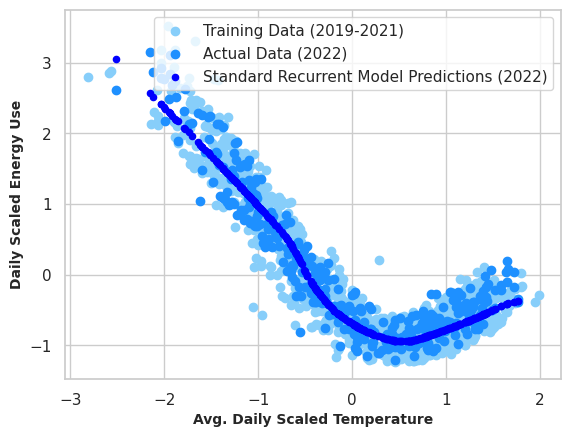

Standard Recurrent Model MAE:
0.221
R2 Score:
0.924


In [ ]:
# Plot the model
sns.set(style="whitegrid")
plt.scatter(X_d_ef_bas_nn, y_d_ef_bas_nn, label='Training Data (2019-2021)', color='lightskyblue')
plt.scatter(X_d_ef_pred_nn, y_d_ef_pred_nn, label='Actual Data (2022)', color='dodgerblue')
plt.scatter(X_d_ef_pred_nn, d_ef_nn_predictions, label='Standard Recurrent Model Predictions (2022)', color='blue', s=20)
plt.xlabel('Avg. Daily Scaled Temperature', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Use', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

print("Standard Recurrent Model MAE:")
print(mae_d_ef_bas_round)
print("R2 Score:")
print(r2_result_d_bas_round)

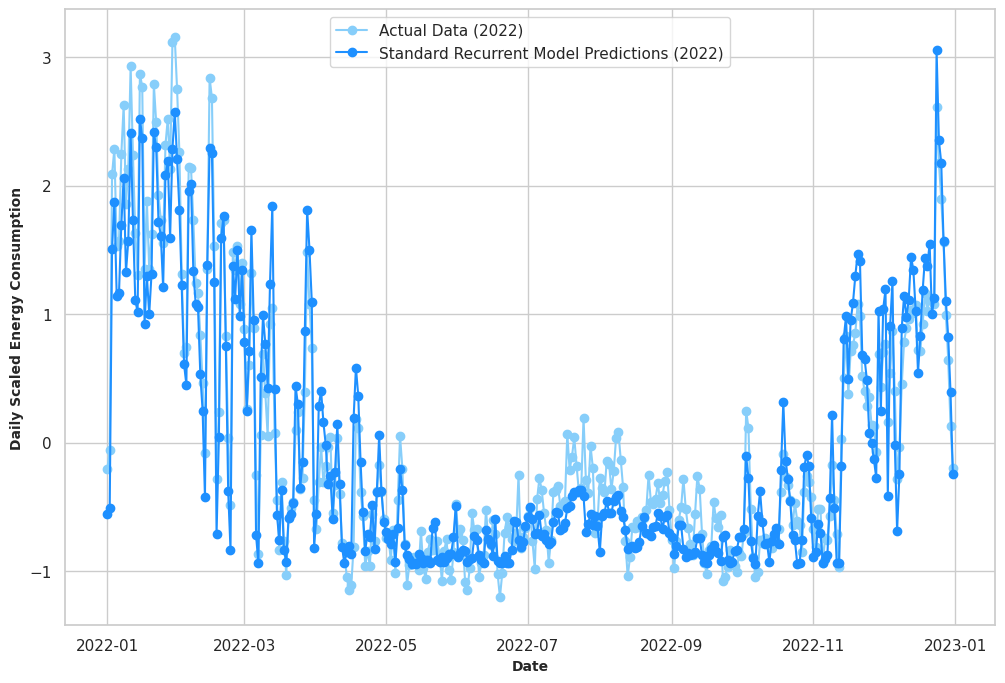

In [ ]:
# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(b1_daily_2022['datetime'], y_d_ef_pred_nn, color='lightskyblue', label='Actual Data (2022)', marker='o')
plt.plot(b1_daily_2022['datetime'], d_ef_nn_predictions, color='dodgerblue', label='Standard Recurrent Model Predictions (2022)', marker='o')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Consumption', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

In [ ]:
# Start with Daily Data, Temperature & Energy Use
# Seperate Data by Year (DAILY)
b1_daily_1922 = b1_daily_df[(b1_daily_df['Year'] == 2019) | (b1_daily_df['Year'] == 2020) | (b1_daily_df['Year'] == 2021) |
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 1)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 2)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 3)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 4)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 5)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 6)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 7)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 8)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 9)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 10)|
                            (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11)] # "Baseline" Years

b1_daily_2022_dec = b1_daily_df[(b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 1)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 2)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 3)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 4)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 5)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 6)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 7)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 8)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 9)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 10)]

In [ ]:
# START WITH BASELINE PERIOD (JAN 2019 - NOV 2022)
X_d_dec_ef_temp = sc_Xd.fit_transform(b1_daily_1922[['Temp']])
Y_d_dec_ef_ener = sc_yd.fit_transform(b1_daily_1922[['EnergyUse']])

# THEN, PREDICITION RANGE (FIRST 10 DAYS OF 2022)
X_d_dec_ef_temp_pred = sc_Xd.fit_transform(b1_daily_2022_dec[['Temp']])
Y_d_dec_ef_ener_pred = sc_yd.fit_transform(b1_daily_2022_dec[['EnergyUse']])

In [ ]:
# Assign data baseline
X_d_dec_ef_bas_nn = X_d_dec_ef_temp.astype(float)
y_d_dec_ef_bas_nn = Y_d_dec_ef_ener.astype(float)

# Assign Data predicition
X_d_dec_ef_pred_nn = X_d_dec_ef_temp_pred.astype(float)
y_d_dec_ef_pred_nn = Y_d_dec_ef_ener_pred.astype(float)

# Split into training and testing (30% test, 70% train)
X_nn_dec_d_ef_bas_train, X_nn_dec_d_ef_bas_test, y_nn_dec_d_ef_bas_train, y_nn_dec_d_ef_bas_test = train_test_split(X_d_dec_ef_bas_nn, y_d_dec_ef_bas_nn, test_size=0.3, random_state=42)

In [ ]:
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, activation='relu', input_shape=input_shape, return_sequences=True),
        SimpleRNN(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for single-step forecasting
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
# Train standard reccurent model
seq_length_d_dec_ef_bas = len(X_d_dec_ef_bas_nn)
model_d_dec_ef = build_rnn_model((seq_length_d_dec_ef_bas, 1))
early_stopping_d_dec_ef = EarlyStopping(patience=10, restore_best_weights=True)

model_d_dec_ef.fit(
    X_nn_dec_d_ef_bas_train, y_nn_dec_d_ef_bas_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_d_dec_ef],
    verbose=1
)

d_dec_ef_nn_test_loss = model_d_ef.evaluate(X_nn_dec_d_ef_bas_test, y_nn_dec_d_ef_bas_test)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7444 - val_loss: 0.6969
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6144 - val_loss: 0.5555
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4724 - val_loss: 0.4190
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3707 - val_loss: 0.2921
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2968 - val_loss: 0.2484
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2755 - val_loss: 0.2482
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2798 - val_loss: 0.2404
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2559 - val_loss: 0.2394
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2670 - val_loss: 0.2447
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2597 - val_loss: 0.2384
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2537 - val_loss: 0.2409
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2487 - val_loss: 0.242

In [ ]:
# Make predicition using trained baseline model
d_dec_ef_nn_predictions = model_d_dec_ef.predict(X_d_dec_ef_pred_nn)

# Extract the MAE from standard model
mae_d_dec_ef_bas_value = mean_absolute_error(y_d_dec_ef_pred_nn, d_dec_ef_nn_predictions)
mae_d_dec_ef_bas_round = round(mae_d_dec_ef_bas_value, 3)

# Extract the R2 from standard model
r2_d_dec_ef_bas_value = r2_score(y_d_dec_ef_pred_nn, d_dec_ef_nn_predictions)
r2_result_d_dec_bas_round = round(r2_d_dec_ef_bas_value, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


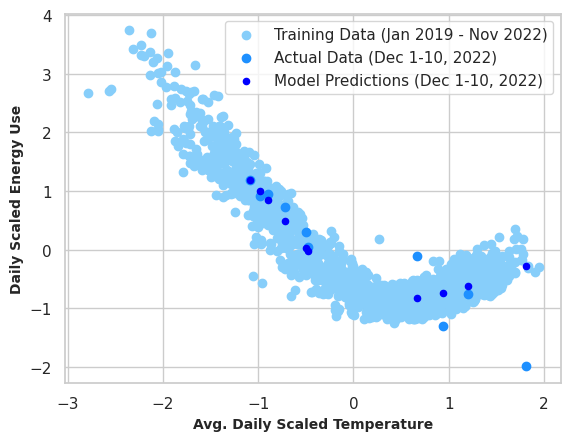

Standard Recurrent Model MAE:
0.389
R2 Score:
0.609


In [ ]:
# Plot the model
sns.set(style="whitegrid")
plt.scatter(X_d_dec_ef_bas_nn, y_d_dec_ef_bas_nn, label='Training Data (Jan 2019 - Nov 2022)', color='lightskyblue')
plt.scatter(X_d_dec_ef_pred_nn, y_d_dec_ef_pred_nn, label='Actual Data (Dec 1-10, 2022)', color='dodgerblue')
plt.scatter(X_d_dec_ef_pred_nn, d_dec_ef_nn_predictions, label='Model Predictions (Dec 1-10, 2022)', color='blue', s=20)
plt.xlabel('Avg. Daily Scaled Temperature', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Use', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

print("Standard Recurrent Model MAE:")
print(mae_d_dec_ef_bas_round)
print("R2 Score:")
print(r2_result_d_dec_bas_round)

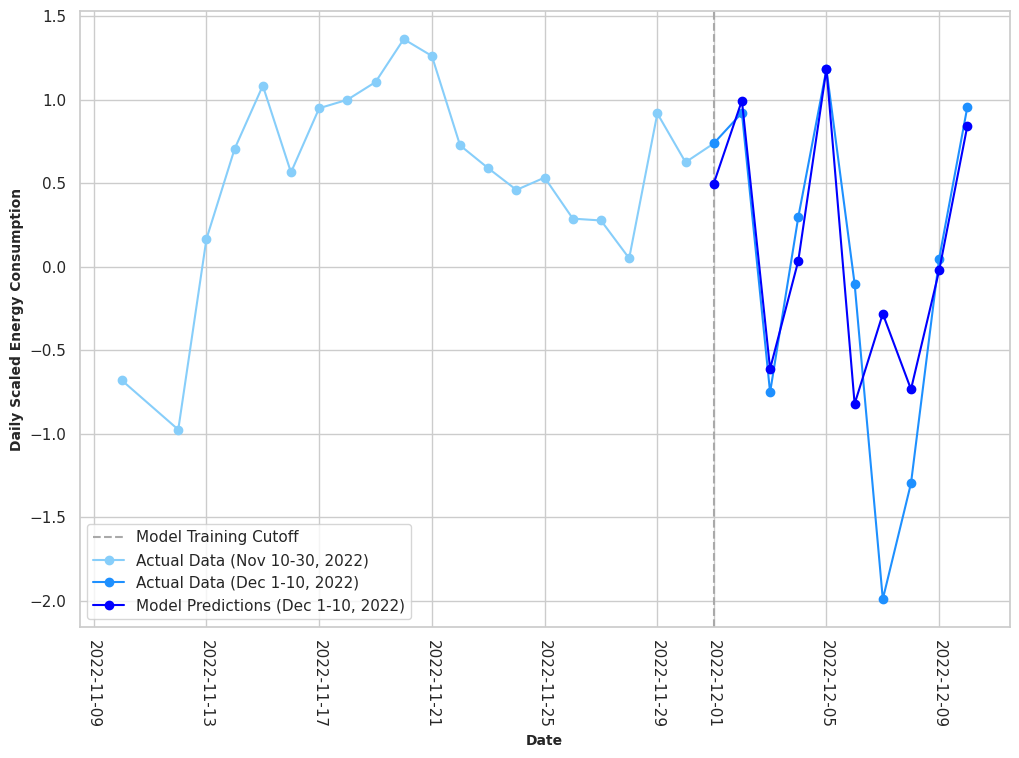

In [ ]:
# Prep portion of plot
b1_daily_2022_nov = b1_daily_df[(b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 10)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 12)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 13)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 14)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 15)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 16)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 17)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 18)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 19)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 20)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 21)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 22)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 23)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 24)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 25)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 26)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 27)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 28)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 29)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 30)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 1)]

pred_cutoff_d_dec_ef = b1_daily_df[(b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 1)]

y_d_nov_ef_pred_nn_weather = y_d_dec_ef_pred_nn[0]
y_d_nov_ef_bas_nn_weather = Y_d_dec_ef_ener[-20:]
y_d_nov_ef_nn_plot = np.concatenate((y_d_nov_ef_bas_nn_weather.flatten(), y_d_nov_ef_pred_nn_weather))

# Plot the data in time series
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.axvline(pred_cutoff_d_dec_ef['datetime'], color='darkgrey', linestyle='--', label='Model Training Cutoff')
plt.plot(b1_daily_2022_nov['datetime'], y_d_nov_ef_nn_plot, color='lightskyblue', label='Actual Data (Nov 10-30, 2022)', marker='o')
plt.plot(b1_daily_2022_dec['datetime'], y_d_dec_ef_pred_nn, color='dodgerblue', label='Actual Data (Dec 1-10, 2022)', marker='o')
plt.plot(b1_daily_2022_dec['datetime'], d_dec_ef_nn_predictions, color='blue', label='Model Predictions (Dec 1-10, 2022)', marker='o')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Consumption', fontweight ='bold', fontsize = 10)
plt.tick_params(axis ='x', rotation = -90)
plt.legend()
plt.show()

# Building 1, SVM (Energy Forecasting, Daily)

In [ ]:
# START WITH BASELINE YEARS (2019-2021)
X_d_ef_svm_temp = sc_Xd.fit_transform(b1_daily_1921[['Temp']])
Y_d_ef_svm_ener = sc_yd.fit_transform(b1_daily_1921[['EnergyUse']])

# THEN, PREDICITION YEAR (2022)
X_d_ef_svm_temp_pred = sc_Xd.fit_transform(b1_daily_2022[['Temp']])
Y_d_ef_svm_ener_pred = sc_yd.fit_transform(b1_daily_2022[['EnergyUse']])

In [ ]:
# Assign data (using just 2019-2021)
X_d_ef_bas_svm = X_d_ef_svm_temp.astype(float)
y_d_ef_bas_svm = Y_d_ef_svm_ener.astype(float)

# Assign Data (2022)
X_d_ef_pred_svm = X_d_ef_svm_temp_pred.astype(float)
y_d_ef_pred_svm = Y_d_ef_svm_ener_pred.astype(float)

In [ ]:
# Create SVR with Radial Basis Function (RBF) kernal
svr_d_ef = SVR(kernel='rbf')

In [ ]:
# Train model with exisiting data
svr_d_ef.fit(X_d_ef_bas_svm, y_d_ef_bas_svm)

# Make predicitions on the data
y_predictions_svm_d_ef = svr_d_ef.predict(X_d_ef_pred_svm)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Check performance of prediction
svr_r2_d_ef_svm = r2_score(y_d_ef_pred_svm, y_predictions_svm_d_ef)
svr_r2_d_ef_svm = round(svr_r2_d_ef_svm, 3)
print("R^2 Correlation for Predicition: ")
print(svr_r2_d_ef_svm)
svr_mae_d_ef_svm = mean_absolute_error(y_d_ef_pred_svm, y_predictions_svm_d_ef)
svr_mae_d_ef_svm = round(svr_mae_d_ef_svm, 3)
print("MAE in Predicition: ")
print(svr_mae_d_ef_svm)

R^2 Correlation for Predicition: 
0.928
MAE in Predicition: 
0.213


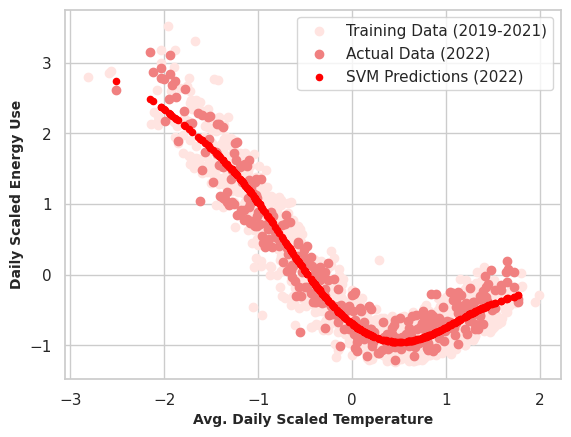

In [ ]:
# Plot the model
sns.set(style="whitegrid")
plt.scatter(X_d_ef_bas_svm, y_d_ef_bas_svm, label='Training Data (2019-2021)', color='mistyrose')
plt.scatter(X_d_ef_pred_svm, y_d_ef_pred_svm, label='Actual Data (2022)', color='lightcoral')
plt.scatter(X_d_ef_pred_svm, y_predictions_svm_d_ef, label='SVM Predictions (2022)', color='red', s=20)
plt.xlabel('Avg. Daily Scaled Temperature', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Use', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

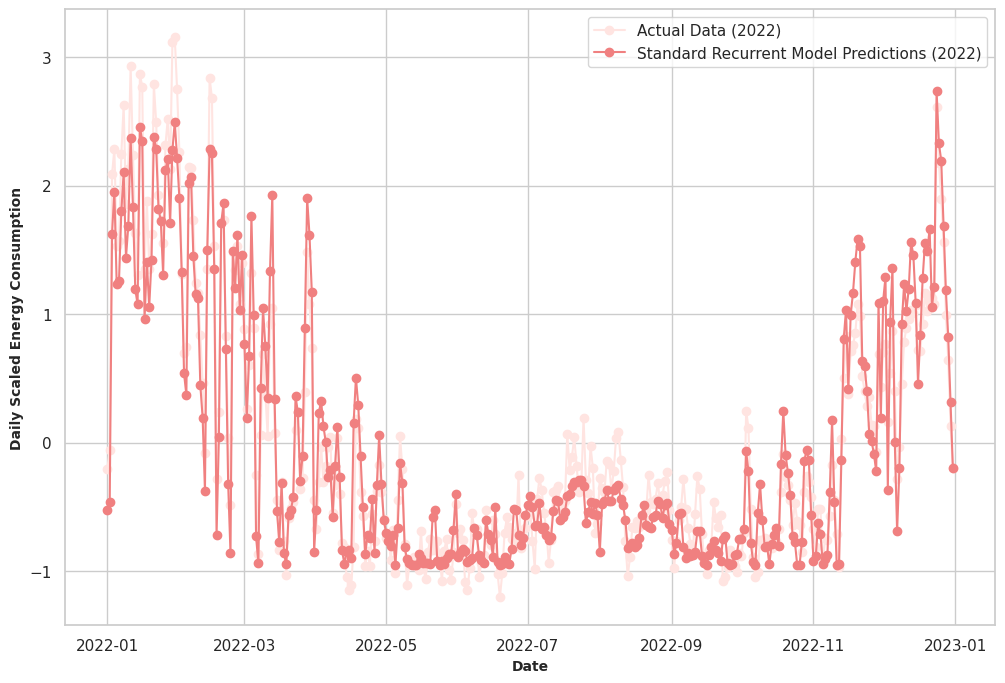

In [ ]:
# Plot the data with anomalies marked in red
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(b1_daily_2022['datetime'], y_d_ef_pred_svm, color='mistyrose', label='Actual Data (2022)', marker='o')
plt.plot(b1_daily_2022['datetime'], y_predictions_svm_d_ef, color='lightcoral', label='Standard Recurrent Model Predictions (2022)', marker='o')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Consumption', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

In [ ]:
# START WITH BASELINE PERIOD (JAN 2019 - NOV 2022)
X_d_dec_ef_temp = sc_Xd.fit_transform(b1_daily_1922[['Temp']])
Y_d_dec_ef_ener = sc_yd.fit_transform(b1_daily_1922[['EnergyUse']])

# THEN, PREDICITION RANGE (FIRST 10 DAYS OF 2022)
X_d_dec_ef_temp_pred = sc_Xd.fit_transform(b1_daily_2022_dec[['Temp']])
Y_d_dec_ef_ener_pred = sc_yd.fit_transform(b1_daily_2022_dec[['EnergyUse']])

# Assign data baseline
X_d_dec_ef_bas_svr = X_d_dec_ef_temp.astype(float)
y_d_dec_ef_bas_svr = Y_d_dec_ef_ener.astype(float)

# Assign Data predicition
X_d_dec_ef_pred_svr = X_d_dec_ef_temp_pred.astype(float)
y_d_dec_ef_pred_svr = Y_d_dec_ef_ener_pred.astype(float)

In [ ]:
# Create SVR with Radial Basis Function (RBF) kernal
svr_d_dec_ef = SVR(kernel='rbf')

In [ ]:
# Train model with exisiting data
svr_d_dec_ef.fit(X_d_dec_ef_bas_svr, y_d_dec_ef_bas_svr)

# Make predicitions on the data
y_predictions_svm_d_dec_ef = svr_d_dec_ef.predict(X_d_dec_ef_pred_svr)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Check performance of prediction
svr_r2_d_dec_ef_svm = r2_score(y_d_dec_ef_pred_svr, y_predictions_svm_d_dec_ef)
svr_r2_d_dec_ef_svm = round(svr_r2_d_dec_ef_svm, 3)
print("R^2 Correlation for Predicition: ")
print(svr_r2_d_dec_ef_svm)
svr_mae_d_dec_ef_svm = mean_absolute_error(y_d_dec_ef_pred_svr, y_predictions_svm_d_dec_ef)
svr_mae_d_dec_ef_svm = round(svr_mae_d_dec_ef_svm, 3)
print("MAE in Predicition: ")
print(svr_mae_d_dec_ef_svm)

R^2 Correlation for Predicition: 
0.565
MAE in Predicition: 
0.432


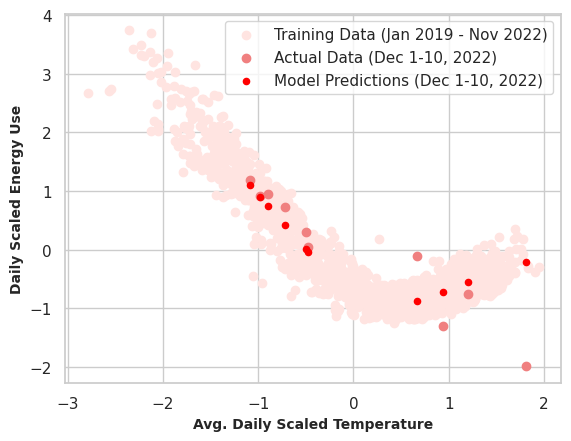

In [ ]:
# Plot the model
sns.set(style="whitegrid")
plt.scatter(X_d_dec_ef_bas_svr, y_d_dec_ef_bas_svr, label='Training Data (Jan 2019 - Nov 2022)', color='mistyrose')
plt.scatter(X_d_dec_ef_pred_svr, y_d_dec_ef_pred_svr, label='Actual Data (Dec 1-10, 2022)', color='lightcoral')
plt.scatter(X_d_dec_ef_pred_svr, y_predictions_svm_d_dec_ef, label='Model Predictions (Dec 1-10, 2022)', color='red', s=20)
plt.xlabel('Avg. Daily Scaled Temperature', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Use', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

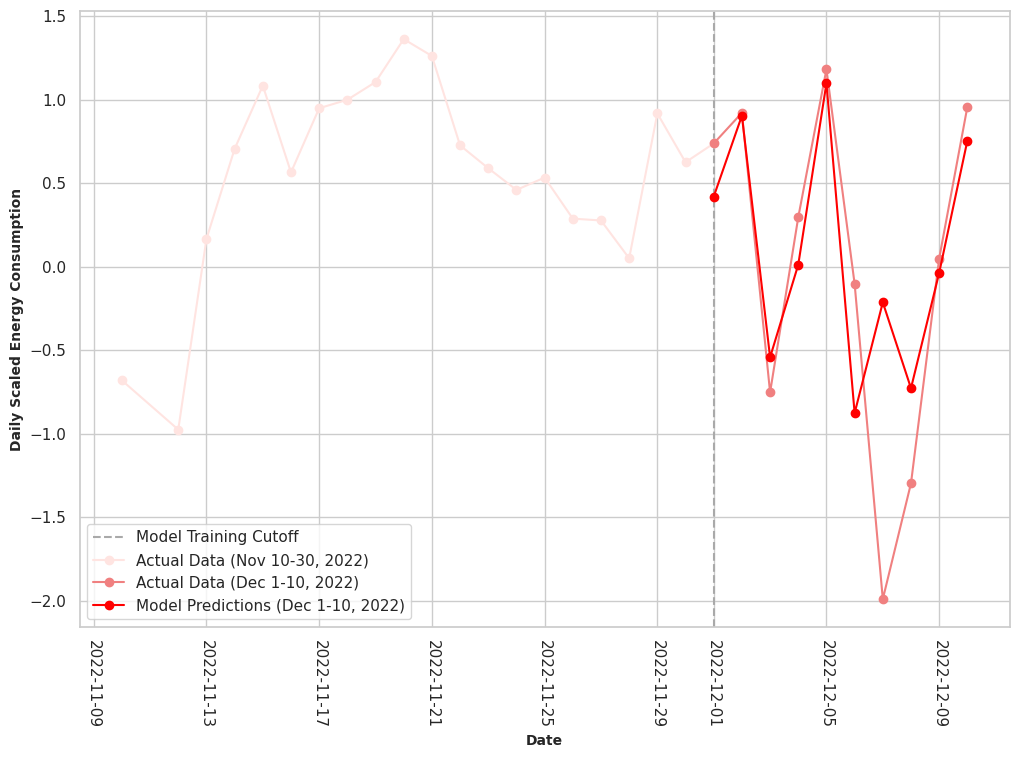

In [ ]:
# Prep portion of plot
b1_daily_2022_nov = b1_daily_df[(b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 10)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 12)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 13)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 14)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 15)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 16)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 17)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 18)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 19)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 20)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 21)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 22)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 23)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 24)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 25)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 26)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 27)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 28)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 29)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 11) & (b1_daily_df['Day'] == 30)|
                              (b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 1)]

pred_cutoff_d_dec_ef = b1_daily_df[(b1_daily_df['Year'] == 2022) & (b1_daily_df['Month'] == 12) & (b1_daily_df['Day'] == 1)]

y_d_nov_ef_pred_svr_weather = y_d_dec_ef_pred_svr[0]
y_d_nov_ef_bas_svr_weather = Y_d_dec_ef_ener[-20:]
y_d_nov_ef_svr_plot = np.concatenate((y_d_nov_ef_bas_svr_weather.flatten(), y_d_nov_ef_pred_svr_weather))

# Plot the data in time series
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.axvline(pred_cutoff_d_dec_ef['datetime'], color='darkgrey', linestyle='--', label='Model Training Cutoff')
plt.plot(b1_daily_2022_nov['datetime'], y_d_nov_ef_svr_plot, color='mistyrose', label='Actual Data (Nov 10-30, 2022)', marker='o')
plt.plot(b1_daily_2022_dec['datetime'], y_d_dec_ef_pred_svr, color='lightcoral', label='Actual Data (Dec 1-10, 2022)', marker='o')
plt.plot(b1_daily_2022_dec['datetime'], y_predictions_svm_d_dec_ef, color='red', label='Model Predictions (Dec 1-10, 2022)', marker='o')
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Consumption', fontweight ='bold', fontsize = 10)
plt.tick_params(axis ='x', rotation = -90)
plt.legend()
plt.show()

# Building 1 (Energy Forecasting, Daily Comparison)

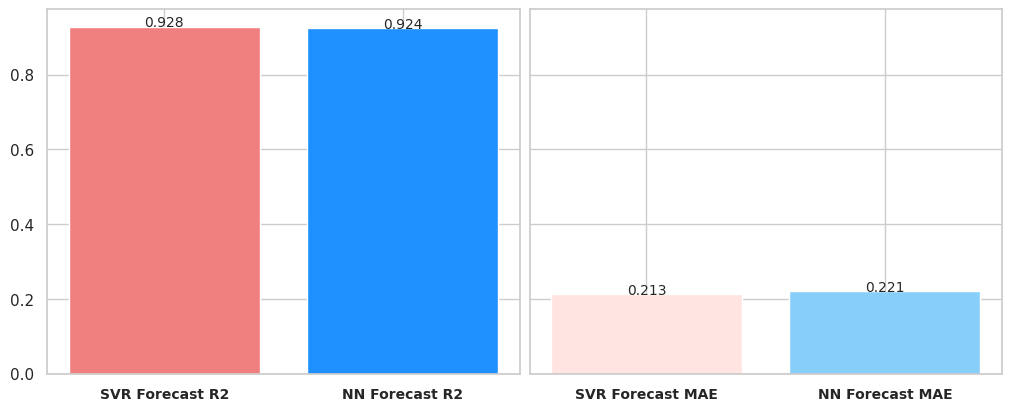

In [ ]:
# Compare monthly R2 and MAE Against Eachother
# Function to place labels at the center of each bar
def add_labels(ax, bar_positions, values):
    for i in range(len(values)):
        ax.text(bar_positions[i], values[i], values[i], ha='center', fontsize=10)  # Aligning text at center

r2_d_values = [svr_r2_d_ef_svm, r2_result_d_bas_round]
mae_d_values = [svr_mae_d_ef_svm, mae_d_ef_bas_round]
r2_d_labels = ["SVR Forecast R2", "NN Forecast R2"]
mae_d_labels = ["SVR Forecast MAE", "NN Forecast MAE"]

bar_positions = np.arange(len(r2_d_values)) # Use length of values to determine bar positions

# Side by side plot
figure,  (ax1, ax2) = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(10, 4))

ax1.bar(bar_positions[0], r2_d_values[0], color ='lightcoral', edgecolor ='w', label =r2_d_labels[0])
ax1.bar(bar_positions[1], r2_d_values[1], color ='dodgerblue', edgecolor ='w', label =r2_d_labels[1])
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(r2_d_labels, fontweight='bold', fontsize='10')
ax1.grid(True)
add_labels(ax1, bar_positions, r2_d_values)


bar_positions_mae = np.arange(len(mae_d_values))
ax2.bar(bar_positions_mae[0], mae_d_values[0], color ='mistyrose', edgecolor ='w', label =mae_d_labels[0])
ax2.bar(bar_positions_mae[1], mae_d_values[1], color ='lightskyblue', edgecolor ='w', label =mae_d_labels[1])
ax2.set_xticks(bar_positions_mae)
ax2.set_xticklabels(mae_d_labels, fontweight='bold', fontsize='10')
ax2.grid(True)
add_labels(ax2, bar_positions_mae, mae_d_values)

plt.show()

# Building 1, NN (Energy Forecasting, Hourly)

In [ ]:
# Start with Hourly Data, Temperature & Energy Use
# Seperate Data by Year (DAILY)
b1_hourly_1922 = b1_hourly_df[(b1_hourly_df['Year'] == 2019) | (b1_hourly_df['Year'] == 2020) | (b1_hourly_df['Year'] == 2021) |
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 1)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 2)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 3)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 4)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 5)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 6)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 7)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 8)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 9)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 10)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 11)] # "Baseline" Years

b1_hourly_2022_dec = b1_hourly_df[(b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 12)]

In [ ]:
# START WITH BASELINE PERIOh (JAN 2019 - NOV 2022)
X_h_ef_temp = sc_Xd.fit_transform(b1_hourly_1922[['Temp']])
Y_h_ef_ener = sc_yd.fit_transform(b1_hourly_1922[['EnergyUse']])

# THEN, PREhICITION RANGE (hEC 2022)
X_h_dec_ef_temp_pred = sc_Xd.fit_transform(b1_hourly_2022_dec[['Temp']])
Y_h_dec_ef_ener_pred = sc_yd.fit_transform(b1_hourly_2022_dec[['EnergyUse']])

In [ ]:
# Assign data baseline
X_h_dec_ef_bas_nn = X_h_ef_temp.astype(float)
y_h_dec_ef_bas_nn = Y_h_ef_ener.astype(float)

# Assign Data predicition
X_h_dec_ef_pred_nn = X_h_dec_ef_temp_pred.astype(float)
y_h_dec_ef_pred_nn = Y_h_dec_ef_ener_pred.astype(float)

# Split into training and testing (30% test, 70% train)
X_nn_dec_h_ef_bas_train, X_nn_dec_h_ef_bas_test, y_nn_dec_h_ef_bas_train, y_nn_dec_h_ef_bas_test = train_test_split(X_h_dec_ef_bas_nn, y_h_dec_ef_bas_nn, test_size=0.3, random_state=42)

In [ ]:
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, activation='relu', input_shape=input_shape, return_sequences=True),
        SimpleRNN(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for single-step forecasting
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
# Train standard reccurent model
seq_length_h_dec_ef_bas = len(X_h_dec_ef_bas_nn)
model_h_dec_ef = build_rnn_model((seq_length_h_dec_ef_bas, 1))
early_stopping_h_dec_ef = EarlyStopping(patience=10, restore_best_weights=True)

model_h_dec_ef.fit(
    X_nn_dec_h_ef_bas_train, y_nn_dec_h_ef_bas_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_h_dec_ef],
    verbose=1
)

h_dec_ef_nn_test_loss = model_h_dec_ef.evaluate(X_nn_dec_h_ef_bas_test, y_nn_dec_h_ef_bas_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.4277 - val_loss: 0.3365
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3473 - val_loss: 0.3335
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3407 - val_loss: 0.3323
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3401 - val_loss: 0.3376
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.3474 - val_loss: 0.3322
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3400 - val_loss: 0.3343
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3389 - val_loss: 0.3315
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3425 - val_loss: 0.3312
Epoch 9/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3397 - val_loss: 0.3313
Epoch 10/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3400 - val_loss: 0.3310
Epoch 11/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3376 - val_loss: 0.3341
Epoch 12/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/ste

In [ ]:
# Make predicition using trained baseline model
h_dec_ef_nn_predictions = model_h_dec_ef.predict(X_h_dec_ef_pred_nn)

# Extract the MAE from standard model
mae_h_dec_ef_bas_value = mean_absolute_error(y_h_dec_ef_pred_nn, h_dec_ef_nn_predictions)
mae_h_dec_ef_bas_round = round(mae_h_dec_ef_bas_value, 3)

# Extract the R2 from standard model
r2_h_dec_ef_bas_value = r2_score(y_h_dec_ef_pred_nn, h_dec_ef_nn_predictions)
r2_result_h_dec_bas_round = round(r2_h_dec_ef_bas_value, 3)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


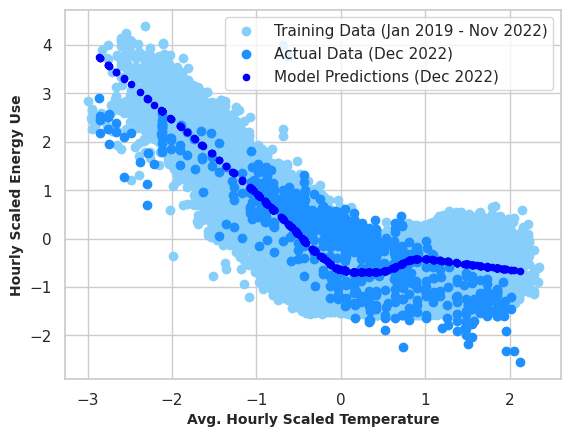

Standard Recurrent Model MAE:
0.578
R2 Score:
0.541


In [ ]:
# Plot the model
sns.set(style="whitegrid")
plt.scatter(X_h_dec_ef_bas_nn, y_h_dec_ef_bas_nn, label='Training Data (Jan 2019 - Nov 2022)', color='lightskyblue')
plt.scatter(X_h_dec_ef_pred_nn, y_h_dec_ef_pred_nn, label='Actual Data (Dec 2022)', color='dodgerblue')
plt.scatter(X_h_dec_ef_pred_nn, h_dec_ef_nn_predictions, label='Model Predictions (Dec 2022)', color='blue', s=20)
plt.xlabel('Avg. Hourly Scaled Temperature', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Scaled Energy Use', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

print("Standard Recurrent Model MAE:")
print(mae_h_dec_ef_bas_round)
print("R2 Score:")
print(r2_result_h_dec_bas_round)

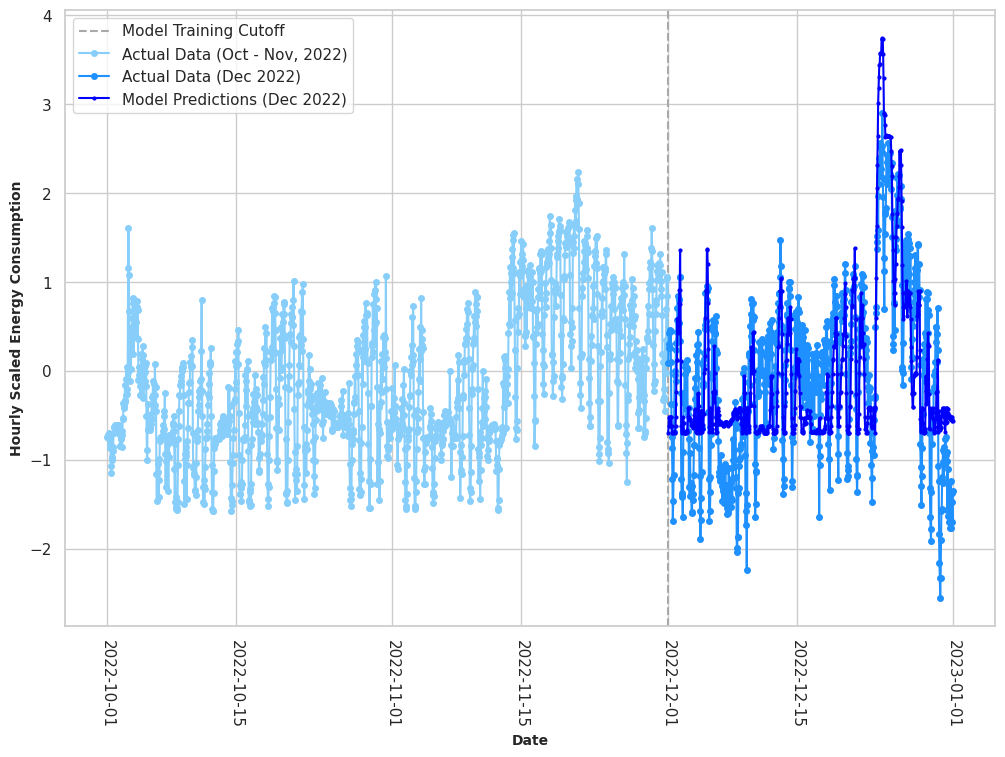

In [ ]:
# Prep portion of plot
b1_hourly_2022_novoct = b1_hourly_df[(b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 10)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 11)]

pred_cutoff_h_dec_ef = b1_hourly_df[(b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 12) & (b1_hourly_df['Day'] == 1) & (b1_hourly_df['Hour'] == 0)]

y_h_octnov_ef_pred_nn_weather = y_h_dec_ef_pred_nn[0]
y_h_octnov_ef_bas_nn_weather = Y_h_ef_ener[-1463:]
y_h_octnov_ef_nn_plot = np.concatenate((y_h_octnov_ef_bas_nn_weather.flatten(), y_h_octnov_ef_pred_nn_weather))

# Plot the data in time series
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.axvline(pred_cutoff_h_dec_ef['datetime'], color='darkgrey', linestyle='--', label='Model Training Cutoff')
plt.plot(b1_hourly_2022_novoct['datetime'], y_h_octnov_ef_nn_plot, color='lightskyblue', label='Actual Data (Oct - Nov, 2022)', marker='o', markersize=4)
plt.plot(b1_hourly_2022_dec['datetime'], y_h_dec_ef_pred_nn, color='dodgerblue', label='Actual Data (Dec 2022)', marker='o', markersize=4)
plt.plot(b1_hourly_2022_dec['datetime'], h_dec_ef_nn_predictions, color='blue', label='Model Predictions (Dec 2022)', marker='o', markersize=2)
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Scaled Energy Consumption', fontweight ='bold', fontsize = 10)
plt.tick_params(axis ='x', rotation = -90)
plt.legend()
plt.show()

# Building 1, SVM (Energy Forecasting, Hourly)

In [ ]:
# Assign data baseline
X_h_dec_ef_bas_svm = X_h_ef_temp.astype(float)
y_h_dec_ef_bas_svm = Y_h_ef_ener.astype(float)

# Assign Data predicition
X_h_dec_ef_pred_svm = X_h_dec_ef_temp_pred.astype(float)
y_h_dec_ef_pred_svm = Y_h_dec_ef_ener_pred.astype(float)

In [ ]:
# Create SVR with Radial Basis Function (RBF) kernal
svr_h_ef = SVR(kernel='rbf')

In [ ]:
# Train model with exisiting data
svr_h_ef.fit(X_h_dec_ef_bas_svm, y_h_dec_ef_bas_svm)

# Make predicitions on the data
y_predictions_svm_h_ef = svr_h_ef.predict(X_h_dec_ef_pred_svm)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Check performance of prediction
svr_r2_h_ef_svm = r2_score(y_h_dec_ef_pred_svm, y_predictions_svm_h_ef)
svr_r2_h_ef_svm = round(svr_r2_h_ef_svm, 3)
print("R^2 Correlation for Predicition: ")
print(svr_r2_h_ef_svm)
svr_mae_h_ef_svm = mean_absolute_error(y_h_dec_ef_pred_svm, y_predictions_svm_h_ef)
svr_mae_h_ef_svm = round(svr_mae_h_ef_svm, 3)
print("MAE in Predicition: ")
print(svr_mae_h_ef_svm)

R^2 Correlation for Predicition: 
0.556
MAE in Predicition: 
0.572


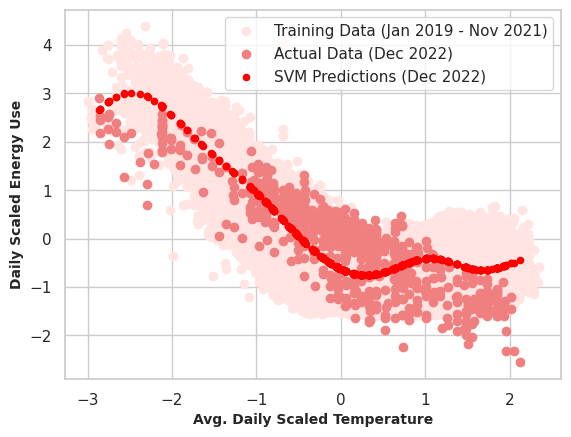

In [ ]:
# Plot the model
sns.set(style="whitegrid")
plt.scatter(X_h_dec_ef_bas_svm, y_h_dec_ef_bas_svm, label='Training Data (Jan 2019 - Nov 2021)', color='mistyrose')
plt.scatter(X_h_dec_ef_pred_svm, y_h_dec_ef_pred_svm, label='Actual Data (Dec 2022)', color='lightcoral')
plt.scatter(X_h_dec_ef_pred_svm, y_predictions_svm_h_ef, label='SVM Predictions (Dec 2022)', color='red', s=20)
plt.xlabel('Avg. Daily Scaled Temperature', fontweight ='bold', fontsize = 10)
plt.ylabel('Daily Scaled Energy Use', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

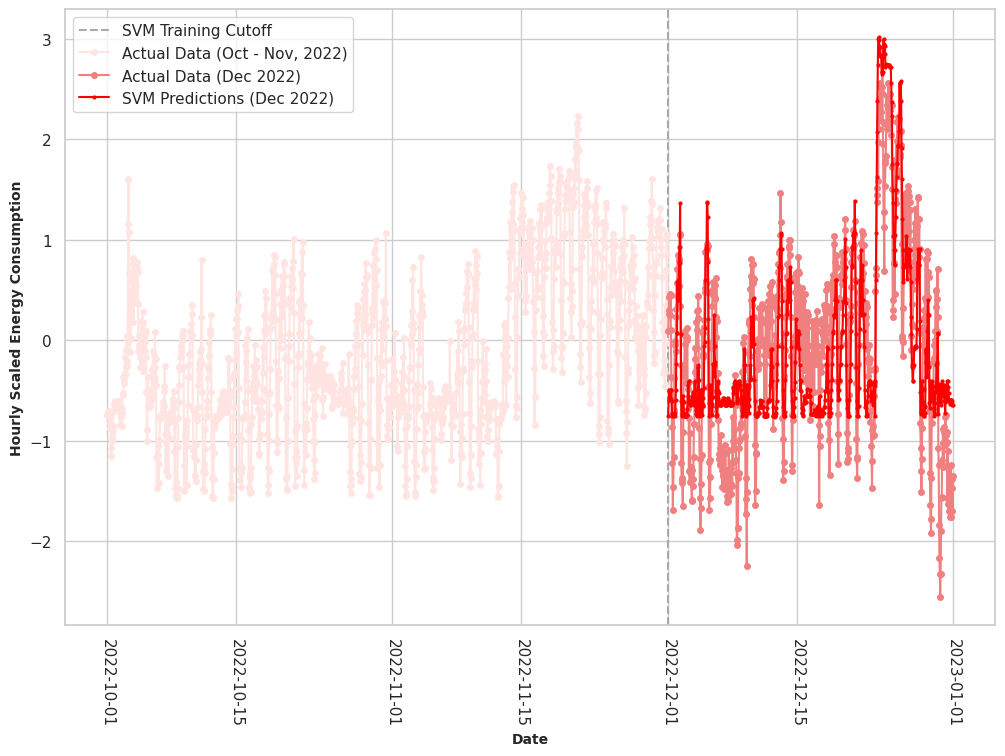

In [ ]:
# Prep portion of plot
b1_hourly_2022_novoct = b1_hourly_df[(b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 10)|
                            (b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 11)]

pred_cutoff_h_dec_ef = b1_hourly_df[(b1_hourly_df['Year'] == 2022) & (b1_hourly_df['Month'] == 12) & (b1_hourly_df['Day'] == 1) & (b1_hourly_df['Hour'] == 0)]

y_h_octnov_ef_pred_svm_weather = y_h_dec_ef_pred_svm[0]
y_h_octnov_ef_bas_svm_weather = Y_h_ef_ener[-1463:]
y_h_octnov_ef_svm_plot = np.concatenate((y_h_octnov_ef_bas_svm_weather.flatten(), y_h_octnov_ef_pred_svm_weather))

# Plot the data in time series
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.axvline(pred_cutoff_h_dec_ef['datetime'], color='darkgrey', linestyle='--', label='SVM Training Cutoff')
plt.plot(b1_hourly_2022_novoct['datetime'], y_h_octnov_ef_svm_plot, color='mistyrose', label='Actual Data (Oct - Nov, 2022)', marker='o', markersize=4)
plt.plot(b1_hourly_2022_dec['datetime'], y_h_dec_ef_pred_svm, color='lightcoral', label='Actual Data (Dec 2022)', marker='o', markersize=4)
plt.plot(b1_hourly_2022_dec['datetime'], y_predictions_svm_h_ef, color='red', label='SVM Predictions (Dec 2022)', marker='o', markersize=2)
plt.xlabel('Date', fontweight ='bold', fontsize = 10)
plt.ylabel('Hourly Scaled Energy Consumption', fontweight ='bold', fontsize = 10)
plt.tick_params(axis ='x', rotation = -90)
plt.legend()
plt.show()

# Building 1 (Energy Forecasting, Hourly Comparison)

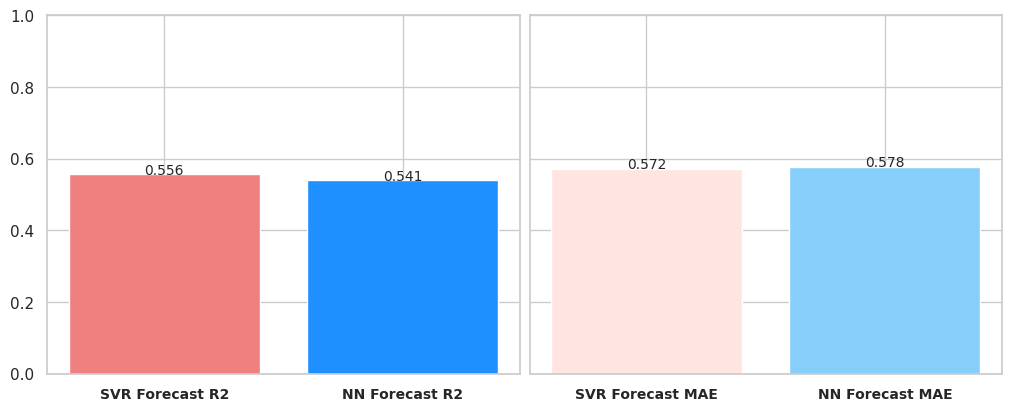

In [ ]:
# Compare monthly R2 and MAE Against Eachother
# Function to place labels at the center of each bar
def add_labels(ax, bar_positions, values):
    for i in range(len(values)):
        ax.text(bar_positions[i], values[i], values[i], ha='center', fontsize=10)  # Aligning text at center

r2_h_values = [svr_r2_h_ef_svm, r2_result_h_dec_bas_round]
mae_h_values = [svr_mae_h_ef_svm, mae_h_dec_ef_bas_round]
r2_h_labels = ["SVR Forecast R2", "NN Forecast R2"]
mae_h_labels = ["SVR Forecast MAE", "NN Forecast MAE"]

bar_positions = np.arange(len(r2_h_values)) # Use length of values to determine bar positions

# Side by side plot
figure,  (ax1, ax2) = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(10, 4))
plt.ylim(0, 1)

ax1.bar(bar_positions[0], r2_h_values[0], color ='lightcoral', edgecolor ='w', label =r2_h_labels[0])
ax1.bar(bar_positions[1], r2_h_values[1], color ='dodgerblue', edgecolor ='w', label =r2_h_labels[1])
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(r2_h_labels, fontweight='bold', fontsize='10')
ax1.grid(True)
add_labels(ax1, bar_positions, r2_h_values)


bar_positions_mae = np.arange(len(mae_h_values))
ax2.bar(bar_positions_mae[0], mae_h_values[0], color ='mistyrose', edgecolor ='w', label =mae_h_labels[0])
ax2.bar(bar_positions_mae[1], mae_h_values[1], color ='lightskyblue', edgecolor ='w', label =mae_h_labels[1])
ax2.set_xticks(bar_positions_mae)
ax2.set_xticklabels(mae_h_labels, fontweight='bold', fontsize='10')
ax2.grid(True)
add_labels(ax2, bar_positions_mae, mae_h_values)

plt.show()